# Import

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:40767")

In [2]:
import sys
sys.path.insert(1, '..')

In [3]:
import numpy as np
import xarray as xr
import scipy
import dask
import gsw
import eos_module
import matplotlib.pyplot as plt

# Data read

In [4]:
from validate_catalog import all_params
params_dict, cat = all_params()

In [5]:
data=[dict() for i in range(6)]
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GS FMA'})
data[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GS ASO'})
data[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'AÇORES FMA'})
data[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'AÇORES ASO'})
data[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'MEDWEST FMA'})
data[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'MEDWEST ASO'})

In [6]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(1,-1,1),y=y_slice,x=x_slice)  
coord_slice = dict(y=y_slice,x=x_slice)

In [7]:
nb_of_time_chunks = 14

In [8]:
%%time
for i in range(len(data)) :
    data[i]['HR'] = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask()\
    .drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')\
    .isel(data_slice)\
    .chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 1.3 s, sys: 128 ms, total: 1.43 s
Wall time: 5.42 s


# Compute true density

In [9]:
%%time
for i in range(len(data)) :
    for dataKey in ['HR'] :
        # density anomaly (sigma0). denoted as 'true' since is computed on the basis of original (non-filtered) HR data
        data[i][dataKey]['sigma0_true'] = xr.apply_ufunc(gsw.density.sigma0, data[i][dataKey]['sosaline'], data[i][dataKey]['sosstsst'], dask='parallelized')
        # sqr of conservative temperature (to compute the subgrid variance further)
        data[i][dataKey]['sst_sqr'] = data[i][dataKey]['sosstsst']**2
        data[i][dataKey]['sal_sqr'] = data[i][dataKey]['sosaline']**2

CPU times: user 71.1 ms, sys: 6.22 ms, total: 77.4 ms
Wall time: 72.4 ms


# Apply filter

In [10]:
coarsening_window_size = 15 # to match eORCA025 resolution

In [11]:
#@dask.delayed
def coarsen(XdataSet, coarsening_window_size) :
    drop_nan_data = data[i]['HR']#.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    area_2d = xr.DataArray((drop_nan_data.e1t * drop_nan_data.e2t), dims=['y','x'])
    wet_mask = xr.DataArray(drop_nan_data.tmask, dims=['y','x'])
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*drop_nan_data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    return result

In [12]:
%%time
for i in range(len(data)) :     
    data[i]['HR_coarsened'] = coarsen(data[i]['HR'], coarsening_window_size).compute()

CPU times: user 14.6 s, sys: 1.17 s, total: 15.7 s
Wall time: 8min 43s


In [13]:
data[i]['HR_coarsened']

<xarray.Dataset>
Dimensions:        (y: 44, x: 38, time_counter: 2206)
Coordinates: (12/17)
    depth          (y, x) float32 766.8 423.0 233.6 ... 2.297e+03 2.459e+03
    e1f            (y, x) float64 1.51e+03 1.51e+03 ... 1.362e+03 1.362e+03
    e1t            (y, x) float64 1.51e+03 1.511e+03 ... 1.362e+03 1.362e+03
    e1u            (y, x) float64 1.51e+03 1.511e+03 ... 1.362e+03 1.362e+03
    e1v            (y, x) float64 1.51e+03 1.51e+03 ... 1.362e+03 1.362e+03
    e2f            (y, x) float64 1.48e+03 1.479e+03 ... 1.256e+03 1.255e+03
    ...             ...
    nav_lat        (y, x) float32 35.59 35.58 35.58 35.58 ... 43.29 43.27 43.26
    nav_lon        (y, x) float32 -1.882 -1.632 -1.381 ... 7.287 7.539 7.791
    time_centered  (time_counter) datetime64[ns] 2009-08-01T01:30:00 ... 2009...
  * time_counter   (time_counter) datetime64[ns] 2009-08-01T01:30:00 ... 2009...
  * x              (x) int64 0 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37
  * y              (y) int64 0 1 2 3 4 5 6 7 8 9 ... 35 36 37 38 39 40 41 42 43
Data variables:
    sosaline       (y, x, time_counter) float64 36.79 36.79 ... 38.05 38.05
    sosstsst       (y, x, time_counter) float64 24.35 24.2 24.11 ... 19.81 19.81
    tmask          (y, x) float64 1.0 1.0 1.0 1.0 nan ... 1.0 1.0 1.0 1.0 1.0
    sigma0_true    (y, x, time_counter) float64 24.75 24.79 ... 26.98 26.98
    sst_sqr        (y, x, time_counter) float64 592.8 585.9 ... 392.5 392.3
    sal_sqr        (y, x, time_counter) float64 1.354e+03 ... 1.447e+03

# Compute the subgrid variance and density error

In [14]:
%%time
for i in range(len(data)) :
    ds = data[i]['HR_coarsened']
    data[i]['HR_coarsened'] = ds.assign(var_T = ds['sst_sqr'] - ds['sosstsst']**2, \
              var_S = ds['sal_sqr'] - ds['sosaline']**2, \
              sigma0_model = xr.apply_ufunc(gsw.density.sigma0, ds['sosaline'], ds['sosstsst'], dask='parallelized'))
    ds = data[i]['HR_coarsened']
    data[i]['HR_coarsened'] = ds.assign(sigma0_delta = ds['sigma0_true'] - ds['sigma0_model'])

CPU times: user 848 ms, sys: 220 ms, total: 1.07 s
Wall time: 1.06 s


# Compute density derivatives

In [15]:
%%time
for i in range(len(data)) :
    ds = data[i]['HR_coarsened'] 
    ds['rho_sa_sa'], ds['rho_sa_ct'], ds['rho_ct_ct'] = eos_module.rho_second_derivatives(ds['sosaline'], ds['sosstsst'])

CPU times: user 14.6 s, sys: 5.12 s, total: 19.7 s
Wall time: 19.7 s


# Compute spatial finite differences for temperature and salinity 

In [16]:
def central_diffs_x(dataArray) :
    return 0.5*(dataArray.shift(x=-1) - dataArray.shift(x=1))
def central_diffs_y(dataArray) :
    return 0.5*(dataArray.shift(y=-1) - dataArray.shift(y=1))

In [17]:
%%time
for i in range(len(data)) :
    ds = data[i]['HR_coarsened']
    data[i]['HR_coarsened'] = ds.assign(diff_T_sqr = central_diffs_x(ds['sosstsst'])**2 + central_diffs_y(ds['sosstsst'])**2,\
                                       diff_S_sqr = central_diffs_x(ds['sosaline'])**2 + central_diffs_y(ds['sosaline'])**2)
    ds = data[i]['HR_coarsened']
    data[i]['HR_coarsened'] = ds.assign(diff_TS = np.sqrt(ds["diff_T_sqr"]*ds["diff_S_sqr"]))

CPU times: user 1.58 s, sys: 373 ms, total: 1.96 s
Wall time: 1.96 s


# Select points in space

In [18]:
x_slice = slice(-25,-5)
y_slice = slice(-33,-13)

data_slice = dict(y=y_slice,x=x_slice)  # take every 50-th hourly output

In [19]:
for i in range(len(data)) :
    data[i]['HR_coarsened_slice'] = (data[i]['HR_coarsened'][data_slice]).copy()

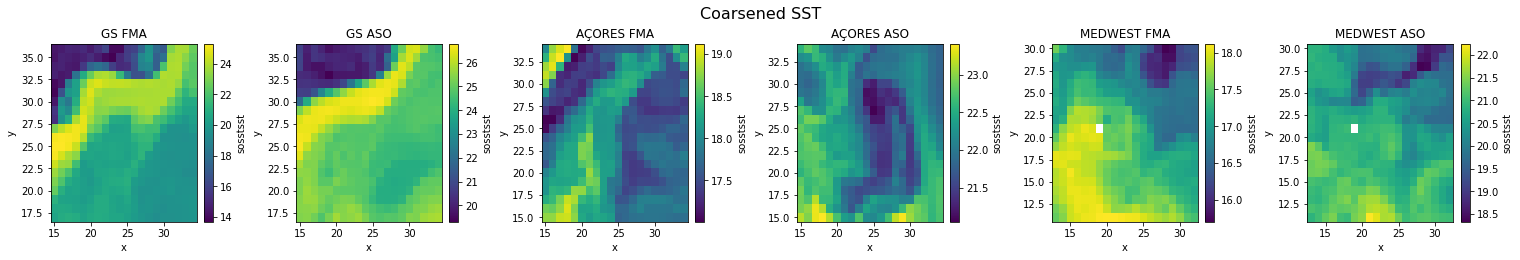

In [20]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(3.5*len(data),3.5), constrained_layout=True)
quantity='sosstsst'
fig.suptitle('Coarsened SST', size=16)
for i in range(len(data)) :
    data[i]['HR_coarsened_slice'].isel(time_counter=-1)[quantity].plot(ax=axis[i])
    axis[i].set(title=data[i]['label'])

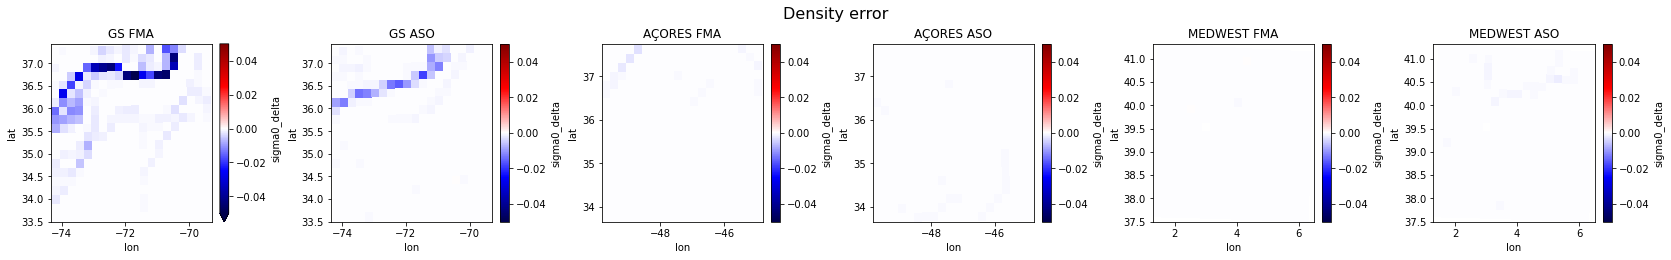

In [21]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(3.85*len(data),3.5), constrained_layout=True)
quantity='sigma0_delta'
fig.suptitle('Density error', size=16)
for i in range(len(data)) :
    data[i]['HR_coarsened_slice'].isel(time_counter=-1)[quantity].plot(x='lon', y='lat', ax=axis[i], cmap='seismic', vmax=0.05, vmin=-0.05)
    axis[i].set(title=data[i]['label'])

In [22]:
for i in range(len(data)) :
    data[i]['HR_coarsened_slice'].coords['x'] = np.arange(len(data[i]['HR_coarsened_slice'].coords['x']))
    data[i]['HR_coarsened_slice'].coords['y'] = np.arange(len(data[i]['HR_coarsened_slice'].coords['y']))

In [23]:
data[i]['HR_coarsened_slice']

<xarray.Dataset>
Dimensions:        (y: 20, x: 20, time_counter: 2206)
Coordinates: (12/17)
    depth          (y, x) float32 2.78e+03 2.786e+03 ... 2.671e+03 2.702e+03
    e1f            (y, x) float64 1.472e+03 1.472e+03 ... 1.406e+03 1.406e+03
    e1t            (y, x) float64 1.472e+03 1.472e+03 ... 1.406e+03 1.406e+03
    e1u            (y, x) float64 1.472e+03 1.472e+03 ... 1.406e+03 1.406e+03
    e1v            (y, x) float64 1.472e+03 1.472e+03 ... 1.406e+03 1.406e+03
    e2f            (y, x) float64 1.421e+03 1.42e+03 ... 1.317e+03 1.315e+03
    ...             ...
    nav_lat        (y, x) float32 37.69 37.68 37.68 37.67 ... 41.08 41.07 41.07
    nav_lon        (y, x) float32 1.428 1.679 1.93 2.181 ... 5.856 6.108 6.359
    time_centered  (time_counter) datetime64[ns] 2009-08-01T01:30:00 ... 2009...
  * time_counter   (time_counter) datetime64[ns] 2009-08-01T01:30:00 ... 2009...
  * x              (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * y              (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables: (12/16)
    sosaline       (y, x, time_counter) float64 37.5 37.5 37.5 ... 37.94 37.93
    sosstsst       (y, x, time_counter) float64 24.47 24.43 ... 19.16 19.16
    tmask          (y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    sigma0_true    (y, x, time_counter) float64 25.23 25.25 ... 27.07 27.07
    sst_sqr        (y, x, time_counter) float64 598.8 596.8 ... 367.0 367.0
    sal_sqr        (y, x, time_counter) float64 1.406e+03 ... 1.439e+03
    ...             ...
    rho_sa_sa      (y, x, time_counter) float64 0.0001966 ... 0.0001737
    rho_sa_ct      (y, x, time_counter) float64 -0.001935 ... -0.002127
    rho_ct_ct      (y, x, time_counter) float64 -0.007726 ... -0.008419
    diff_T_sqr     (y, x, time_counter) float64 0.02516 0.02449 ... 0.1672
    diff_S_sqr     (y, x, time_counter) float64 0.006356 0.006363 ... 0.008229
    diff_TS        (y, x, time_counter) float64 0.01265 0.01248 ... 0.03709

# Write dataset

In [24]:
# drop useless variables and coordiantes
for i in range(len(data)) :
    data[i]['HR_coarsened_slice'] = data[i]['HR_coarsened_slice'].drop(['time_centered', 'tmask', 'nav_lat', 'nav_lon', 'depth', 'e1f', 'e2f', 'e1u', 'e2u', 'e1v', 'e2v', 'e1t', 'e2t', 'sigma0_true', 'sst_sqr', 'sal_sqr'], errors='ignore')
    data[i]['HR_coarsened_slice'].attrs['label'] = data[i]['label']

In [25]:
for i in range(len(data)) :
    data[i]['HR_coarsened_slice'].attrs['region'] = data[i]['region']
    data[i]['HR_coarsened_slice'].attrs['season'] = data[i]['season']

In [26]:
data[i]['HR_coarsened_slice']

<xarray.Dataset>
Dimensions:       (y: 20, x: 20, time_counter: 2206)
Coordinates:
    lat           (y, x) float32 37.69 37.68 37.68 37.67 ... 41.08 41.07 41.07
    lon           (y, x) float32 1.428 1.679 1.93 2.181 ... 5.856 6.108 6.359
  * time_counter  (time_counter) datetime64[ns] 2009-08-01T01:30:00 ... 2009-...
  * x             (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * y             (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    sosaline      (y, x, time_counter) float64 37.5 37.5 37.5 ... 37.94 37.93
    sosstsst      (y, x, time_counter) float64 24.47 24.43 24.39 ... 19.16 19.16
    var_T         (y, x, time_counter) float64 0.003411 0.00328 ... 0.02652
    var_S         (y, x, time_counter) float64 0.001298 0.001292 ... 0.0009649
    sigma0_model  (y, x, time_counter) float64 25.23 25.25 25.26 ... 27.07 27.07
    sigma0_delta  (y, x, time_counter) float64 -1.682e-05 ... -0.000101
    rho_sa_sa     (y, x, time_counter) float64 0.0001966 0.0001965 ... 0.0001737
    rho_sa_ct     (y, x, time_counter) float64 -0.001935 -0.001936 ... -0.002127
    rho_ct_ct     (y, x, time_counter) float64 -0.007726 -0.007731 ... -0.008419
    diff_T_sqr    (y, x, time_counter) float64 0.02516 0.02449 ... 0.1647 0.1672
    diff_S_sqr    (y, x, time_counter) float64 0.006356 0.006363 ... 0.008229
    diff_TS       (y, x, time_counter) float64 0.01265 0.01248 ... 0.03709
Attributes:
    label:    MEDWEST ASO
    region:   3
    season:   aso

In [27]:
# # pandas format
# for i in range(len(data)) :
#     for it, counter in enumerate(data[i]['HR_Filtered']['time_counter']) :
#         (data[i]['HR_Filtered'].isel(time_counter=it).drop('time_counter')).to_dataframe().to_csv("datasets/dataset"+str(i)+"_it"+str(it)+".csv")

In [28]:
# netcdf format
for i in range(len(data)) :
    data[i]['HR_coarsened_slice'].to_netcdf("datasets/dataset"+str(i)+".nc")

In [29]:
index_table = np.transpose(np.stack([np.concatenate([np.full(len(data[i]['HR']['time_counter']), i) for i in range(len(data))]),\
         np.concatenate([np.arange(len(data[i]['HR']['time_counter'])) for i in range(len(data))])]))

In [30]:
index_table.shape

(13020, 2)